<a href="https://colab.research.google.com/github/Dhanushi-Pemarathna/Dhanushi-Pemarathne/blob/main/Sport_celebrity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import urllib.request
import shutil
import pywt

from google.colab import drive

drive.mount('/content/drive')

# Change working directory to dataset location
os.chdir("/content/drive/MyDrive/Project/C2/Dataset")

def download_cascades():
    face_url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml"
    eye_url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml"
    urllib.request.urlretrieve(face_url, "haarcascade_frontalface_default.xml")
    urllib.request.urlretrieve(eye_url, "haarcascade_eye.xml")

download_cascades()

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

# Define dataset paths
path_to_data = "/content/drive/MyDrive/Project/C2/Dataset/"
path_to_cr_data = os.path.join(path_to_data, "cropped")



# Create cropped images directory
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]

celebrity_file_names_dict = {}
cropped_image_dirs = []

for img_dir in img_dirs:
    celebrity_name = os.path.basename(img_dir)
    print(f"Processing {celebrity_name}...")
    celebrity_file_names_dict[celebrity_name] = []
    count = 1

    for entry in os.scandir(img_dir):
        if entry.is_file():  # Ensure it's a file before processing
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print(f"Generating cropped images in: {cropped_folder}")

                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

Mounted at /content/drive
Processing roger_federer...
Generating cropped images in: /content/drive/MyDrive/Project/C2/Dataset/cropped/roger_federer
Processing lionel_messi...
Generating cropped images in: /content/drive/MyDrive/Project/C2/Dataset/cropped/lionel_messi
Processing virat_kohli...
Generating cropped images in: /content/drive/MyDrive/Project/C2/Dataset/cropped/virat_kohli
Processing maria_sharapova...
Generating cropped images in: /content/drive/MyDrive/Project/C2/Dataset/cropped/maria_sharapova
Processing serena_williams...
Generating cropped images in: /content/drive/MyDrive/Project/C2/Dataset/cropped/serena_williams
Processing cropped...


### Wavelet transform


In [ ]:
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Fixed incorrect conversion
    imArray = np.float32(imArray) / 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode) * 255
    return np.uint8(imArray_H)

class_dict = {name: idx for idx, name in enumerate(celebrity_file_names_dict.keys())}

x, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            print(f"Error reading {training_image}")
            continue

        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img = cv2.resize(img_har, (32, 32))

        combined_img = np.vstack((scaled_raw_img.reshape(32 * 32 * 3, 1),
                                  scaled_img.reshape(32 * 32, 1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

print(f"Dataset size: {len(x)} images")


Dataset size: 186 images


In [ ]:
len(x)

186

In [ ]:
len(y)

186

In [ ]:
len(x[0])

4096

In [ ]:
32*32*3 + 32*32

4096

In [ ]:
x[0]

array([[ 34],
       [ 49],
       [ 60],
       ...,
       [118],
       [239],
       [225]], dtype=uint8)

In [ ]:
x = np. array(x).reshape(len(x), 4096).astype(float)
x.shape

(186, 4096)

## 5th video - training the model

### data cleaning process is done. now we are ready to train our model

we will use SVM with rbf kernel tuned with heuristic finetuning


In [ ]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6595744680851063

In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.67      0.60      0.63        10
           2       0.64      0.90      0.75        10
           3       0.80      0.40      0.53        10
           4       0.67      0.80      0.73        10

    accuracy                           0.66        47
   macro avg       0.67      0.65      0.64        47
weighted avg       0.68      0.66      0.65        47




Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

,model,best_score,best_params
0,svm,0.784392,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.641270,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.835185,{'logisticregression__C': 1}


In [ ]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.6595744680851063

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.6170212765957447

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7021276595744681

In [ ]:
best_clf = max(best_estimators, key=lambda k: best_estimators[k].score(X_test, y_test))
best_clf = best_estimators[best_clf]
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, multi_class='auto',
                                    solver='liblinear'))])

In [ ]:

#best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 0, 0, 0, 2],
       [0, 8, 0, 1, 1],
       [1, 0, 8, 1, 0],
       [0, 1, 0, 5, 4],
       [1, 0, 0, 2, 7]])

Text(95.72222222222221, 0.5, 'Truth')

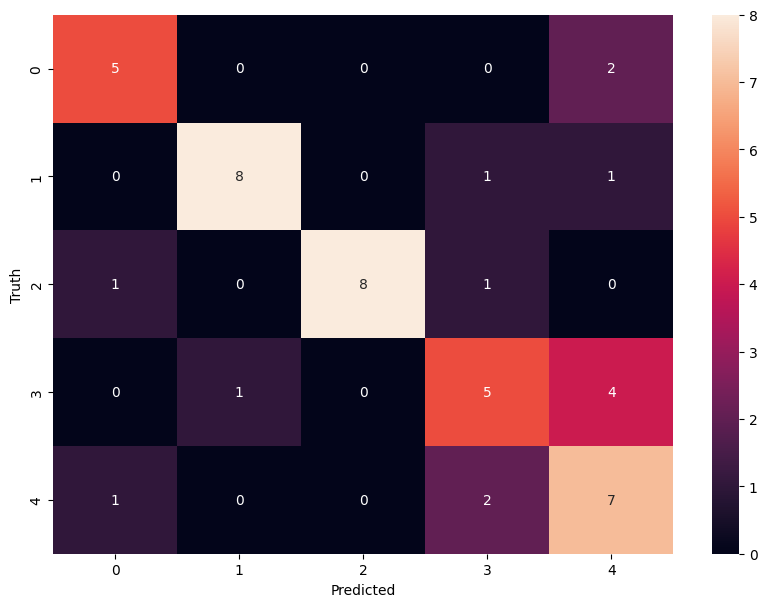

In [ ]:

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:

class_dict

{'roger_federer': 0,
 'lionel_messi': 1,
 'virat_kohli': 2,
 'maria_sharapova': 3,
 'serena_williams': 4,
 'cropped': 5}

##Save the trained model


In [ ]:
!pip install joblib
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

##Save class dictionary

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))